### Preparando os dados

In [1]:
# Unquoting data 
from urllib.parse import unquote

files = ['links', 'categories']

for i in files:
    text_file = open(f'./my_data/wiki/{i}.csv', "r")
    data = text_file.read()
    text_file.close()

    unquoted_data = unquote(data)

    f = open(f'./my_data/wiki/{i}_unquoted.csv', "a")
    f.write(unquoted_data)
    f.close()


In [2]:
## Create dataframes from links file
import networkx as nx
import pandas as pd
import numpy as np

# Read the edge list from the file
df1 = pd.read_csv('./my_data/wiki/links_unquoted.csv', delimiter=';', header = None)

### Definição de funções

In [3]:
import matplotlib.pyplot as plt
#%matplotlib inline

def show_histogram(xvalues=None, yvalues=None, figsize=(5,5), xlabel='Values', ylabel='Count', normalized=False):
    h_deg = xvalues
    if xvalues == None:
        h_deg = list( range(0, len(yvalues)) )
    v_deg = yvalues
    if yvalues == None:
        v_deg = list( range(0, len(xvalues)) )
    plt.figure(figsize=figsize, tight_layout = True)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.xticks(rotation = 60)
    plt.bar(h_deg, v_deg, color = 'b') 
    plt.show()

# Hyperlinks on Wikipedia

Esta é uma rede de páginas da Wikipedia, onde os nós são páginas e as arestas representam hyperlinks entre duas páginas. É uma rede que representa um subconjunto da wikipedia, contendo 4096 páginas e 106647 links.
A rede foi criada para ser utilizada no jogo Wikispeedia, onde eram dadas aos jogadores uma página inicial e uma página alvo e os jogadores deveriam, partindo da página inicial, chegar à página alvo navegando pelos links entre as páginas.
Foram coletados dados dos caminhos percorridos pelos jogadores bem como os caminhos que não foram concluídos.
Cada página também contém um atributo chamado categoria, que classifica o conteúdo da página (história, química, música etc). 

Fonte: https://snap.stanford.edu/data/wikispeedia.html

### Montagem do grafo

Cada página será um nó e se uma página A contem um link para uma página B então é inserida uma aresta direcionada A -> B.
Porém o grafo é não direcionado devido à sessão de referências.
Cada nó possui os atributos **Category** e **Macrocategory** classificando a página de acordo com o tema.

Exemplos de categorias e subcategorias:

 - **Página**: Brazil
   - **Category**: subject.Geography.Central_and_South_American_Geography.Central_and_South_American_Countries
   - **MacroCategory**: Geography
 - **Página**: Albert_Einstein
   - **Category**: subject.People.Astronomers_and_physicists 
   - **Macrocategory**: People

In [4]:
## Mount graph

G = nx.Graph()
for i in range(len(df1)):
    G.add_node(df1.loc[i,0], label = df1.loc[i,0], category = '', macrocategory= '') # Add node A with -1 as attribute
    G.add_node(df1.loc[i,1], label = df1.loc[i,1], category = '', macrocategory= '') # Add node B with -1 as attribute
    G.add_edge(df1.loc[i,0], df1.loc[i,1])        # Add edge (A,B) to the network
    

## Add category property to nodes
df2 = pd.read_csv('./my_data/wiki/categories_unquoted.csv', delimiter=';', header = None)

for i in range(len(df2)):
    G.add_node(df2.loc[i,0], label = df2.loc[i,0], category = df2.loc[i,1], macrocategory = df2.loc[i,1].split('.')[1])

[('Science', 1094), ('Geography', 907), ('People', 667), ('History', 415), ('Everyday_life', 314), ('Design_and_Technology', 221), ('Citizenship', 199), ('Language_and_literature', 185), ('Countries', 136), ('Religion', 129), ('Music', 97), ('IT', 80), ('Business_Studies', 75), ('Mathematics', 45), ('Art', 34), ('', 4)]


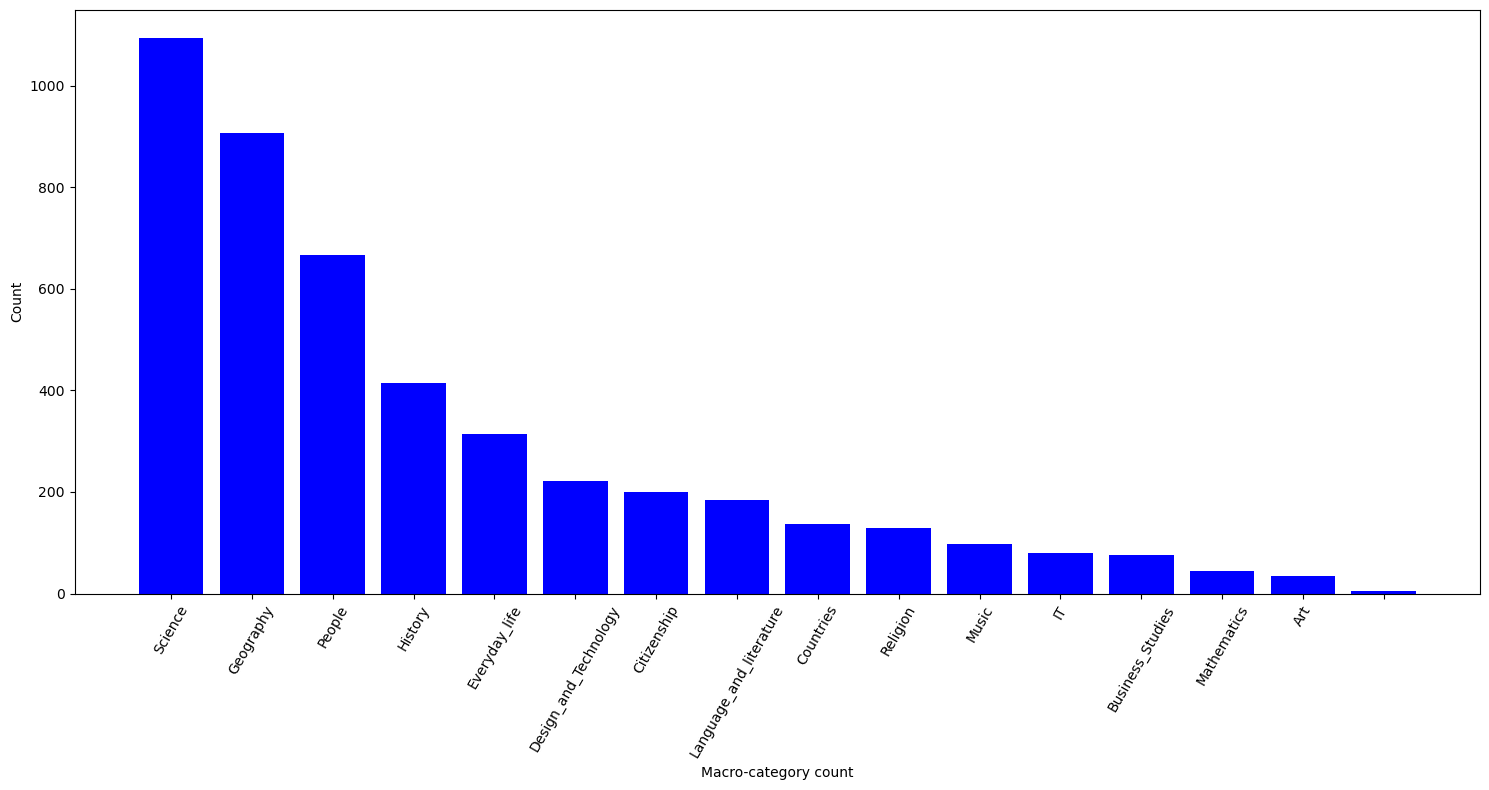

In [5]:
## Macro-Category distribution
from operator import itemgetter

categories_list = list(nx.get_node_attributes(G, 'macrocategory').values())
categories_set = set(categories_list)
x = []

for item in categories_list:
    if item not in [row[0] for row in x]:
        x.append((item, 1))
    else:
        idx = [row[0] for row in x].index(item)
        x[idx] = (item, x[idx][1]+1)

x = sorted(x, key=itemgetter(1), reverse=True)
print(x)

show_histogram(yvalues=[row[1] for row in x], xvalues=[row[0] for row in x], figsize=(15,8), xlabel='Macro-category count')

[('subject.Science.Biology.Birds', 160), ('subject.Countries', 136), ('subject.Geography.Geography_of_Great_Britain', 119), ('subject.Science.Chemistry.Chemical_elements', 117), ('subject.Science.Biology.Mammals', 114), ('subject.Science.Biology.Plants', 107), ('subject.Science.Biology.Health_and_medicine', 106), ('subject.People.Historical_figures', 103), ('subject.Science.Physics.Space_Astronomy', 103), ('subject.Geography.North_American_Geography', 99), ('subject.Citizenship.Politics_and_government', 97), ('subject.Design_and_Technology.Railway_transport', 84), ('subject.Geography.European_Geography', 80), ('subject.History.General_history', 76), ('subject.Geography.Geology_and_geophysics', 75), ('subject.Geography.African_Geography', 74), ('subject.Science.Biology.Insects_Reptiles_and_Fish', 72), ('subject.People.Writers_and_critics', 71), ('subject.Geography.Geography_of_Asia', 69), ('subject.History.Military_History_and_War', 67), ('subject.People.Political_People', 64), ('subjec

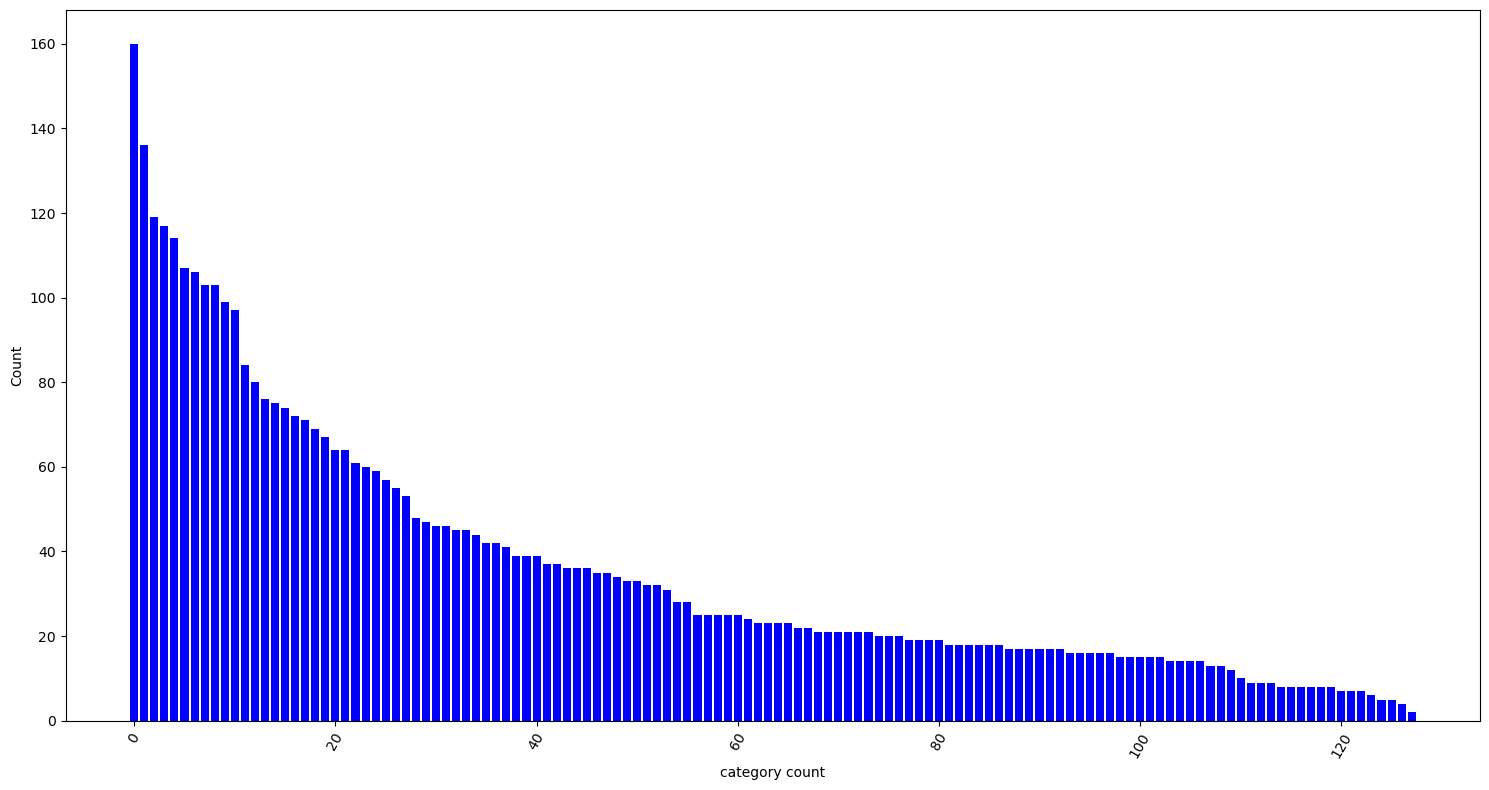

In [6]:
## Category distribution
from operator import itemgetter

categories_list = list(nx.get_node_attributes(G, 'category').values())
categories_set = set(categories_list)
x = []

for item in categories_list:
    if item not in [row[0] for row in x]:
        x.append((item, 1))
    else:
        idx = [row[0] for row in x].index(item)
        x[idx] = (item, x[idx][1]+1)

x = sorted(x, key=itemgetter(1), reverse=True)
print(x)

show_histogram(yvalues=[row[1] for row in x], figsize=(15,8), xlabel='category count')

## Degree Analisys

In [27]:
## Number of nodes and edges
print("Number of nodes: %d" %G.number_of_nodes() )
print("Number of edges: %d" %G.number_of_edges() )
print(f'Average Degree: {sum([degree[1] for degree in G.degree()])/G.number_of_nodes()}')
sorted_degrees = sorted(G.degree(), key=itemgetter(1), reverse=True)
print(f'Max degree: {sorted_degrees[0][1]} in node {sorted_degrees[0][0]}')

'''# In degree
print(f'Average In Degree: {sum([degree[1] for degree in G.in_degree()])/G.number_of_nodes()}')
sorted_in_degrees = sorted(G.degree(), key=itemgetter(1), reverse=True)
print(f'Max In degree: {sorted_in_degrees[0][1]} in node {sorted_in_degrees[0][0]}')

# Out degree
print(f'Average Out Degree: {sum([degree[1] for degree in G.out_degree()])/G.number_of_nodes()}')
sorted_out_degrees = sorted(G.degree(), key=itemgetter(1), reverse=True)
print(f'Max Out degree: {sorted_out_degrees[0][1]} in node {sorted_out_degrees[0][0]}')'''

Number of nodes: 4602
Number of edges: 119882
Average Degree: 52.09995654063451
Max degree: 1845 in node United_States


"# In degree\nprint(f'Average In Degree: {sum([degree[1] for degree in G.in_degree()])/G.number_of_nodes()}')\nsorted_in_degrees = sorted(G.degree(), key=itemgetter(1), reverse=True)\nprint(f'Max In degree: {sorted_in_degrees[0][1]} in node {sorted_in_degrees[0][0]}')\n\n# Out degree\nprint(f'Average Out Degree: {sum([degree[1] for degree in G.out_degree()])/G.number_of_nodes()}')\nsorted_out_degrees = sorted(G.degree(), key=itemgetter(1), reverse=True)\nprint(f'Max Out degree: {sorted_out_degrees[0][1]} in node {sorted_out_degrees[0][0]}')"

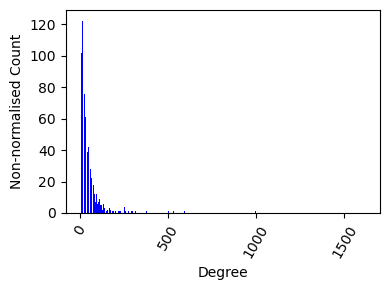

In [7]:
# Plot the degree distribution
show_histogram(yvalues=nx.degree_histogram(G), figsize = (4,3), ylabel='Non-normalised Count', xlabel='Degree')


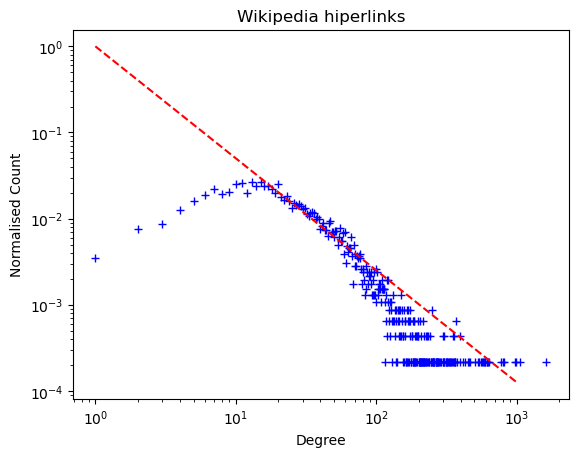

In [9]:
## Degree distribution (log)
import networkx as nx
import matplotlib.pyplot as plt

# REMOVE MULTIPLE EDGES AND SELF-LOOPS
G = nx.Graph(G)                                 # Remove multiple edges
G.remove_edges_from( nx.selfloop_edges(G) )     # Remove self-loops

# Make the histogram of degree, i.e. the number of nodes with a certain degree
h_deg = nx.degree_histogram(G)                              # calculate the degree histogram
h_deg_n = [x / nx.number_of_nodes(G) for x in h_deg]        # normalise the histogram to make a pdf
v_deg = list( range(0,len(h_deg)))                          # create a list of degree values, from 0 to len(h_deg)

# Draw the histogram, using log-scale on the axes (why? try without log-scale)
plt.title('Wikipedia hiperlinks')
plt.ylabel('Normalised Count')
plt.xlabel('Degree')
plt.yscale('log')
plt.xscale('log')
#plt.bar(v_deg, h_deg_n, width=0.8, color='b')  # this plot using "bars", but "bars" are not good when using log-scale in the axes - DO NOT USE IT UNLESS THE HISTOGRAM IS SMALL!
plt.plot(v_deg, h_deg_n, 'b+')

# Draw an eye-guide curve. In this case a power-law with exponent 1.8
list_x = list( range(1,1000) )                    # Create the values for the x-axis and convert to a list
list_y = list( [ 1/(i**1.3) for i in list_x ] )   # Create the values for the y-axis and convert to a list:
                                                  # this code is called "list comprehension" [ 1/(i**1.8) for i in list_x ] -> for each item "i" in the list "list_x", the output is "1/(i**1.8)"
plt.plot(list_x, list_y, 'r--')

plt.show()

## Giant component

In [11]:
## Has giant component?

Gcc = sorted( nx.connected_components(G), key=len, reverse=True)
print(f'Number of connected components: {len(Gcc)}')

#for idx in range(len(Gcc)):
#    print(f'Number of nodes of connected component {idx}: {G.subgraph( Gcc[idx] ).number_of_nodes()}')
#    print(f'Number of edges of connected component {idx}: {G.subgraph( Gcc[idx] ).number_of_edges()}')

# Make a subgraph "H" of "G" containing only the giant component, i.e. Gcc[0]
H = G.subgraph( Gcc[0] ).copy()

Number of connected components: 12
Number of nodes of connected component 0: 4589
Number of edges of connected component 0: 106534
Number of nodes of connected component 1: 3
Number of edges of connected component 1: 3
Number of nodes of connected component 2: 1
Number of edges of connected component 2: 0
Number of nodes of connected component 3: 1
Number of edges of connected component 3: 0
Number of nodes of connected component 4: 1
Number of edges of connected component 4: 0
Number of nodes of connected component 5: 1
Number of edges of connected component 5: 0
Number of nodes of connected component 6: 1
Number of edges of connected component 6: 0
Number of nodes of connected component 7: 1
Number of edges of connected component 7: 0
Number of nodes of connected component 8: 1
Number of edges of connected component 8: 0
Number of nodes of connected component 9: 1
Number of edges of connected component 9: 0
Number of nodes of connected component 10: 1
Number of edges of connected com

A rede possui um componente gigante com 4596 nós. Isso representa aproximadamente 99.86% da rede. Portanto, de agora em diante, usaremos o componente gigante para calcular as demais métricas.

## Centrality metrics

In [12]:
## Centrality metrics
# Some solutions

# Calculate the relevant network measures and organise the data into a dataframe

# Degree centrality -> that is the same as the degree but normalised by N-1
k_cent = nx.degree_centrality(H)

# Betweenness centrality -> normalised by 2/((n-1)(n-2))
b_cent = nx.betweenness_centrality(H)

# Page-Rank centrality
pr_cent = nx.pagerank(H)

# Eigenvector centrality
# but the network in undirected! therefore, better to use eigenvector centrality
# note that the method nx.pagerank() above works with undirected network by assuming that all edges are bidirectional
ev_cent = nx.eigenvector_centrality(H)

# clustering coefficient of each node
cc = nx.clustering(H)

# Save the network measures of each node, that is originally in a dictionary, to dataframes
df1 = pd.DataFrame.from_dict(k_cent, orient='index', columns = ['degree'])
df2 = pd.DataFrame.from_dict(b_cent, orient='index', columns = ['betweenness'])
df3 = pd.DataFrame.from_dict(ev_cent, orient='index', columns = ['eigenvector'])
df4 = pd.DataFrame.from_dict(cc, orient='index', columns = ['clustering'])

# Save the attributes of each node, that are originally stored as node attributes, in dataframes
# Note that here I include the node column to make sure the index will store the node ID
df5 = pd.DataFrame( list(H.nodes(data = 'category') ), columns = ['node','category'])
df5 = df5.set_index('node')


# Combine all dataframes into a single dataframe
network_measures = pd.concat([df1, df2, df3, df4, df5], axis = 1)

pd.set_option('display.max_rows', 20)

network_measures

,degree,betweenness,eigenvector,clustering,category
Áedán_mac_Gabráin,0.002398,1.473365e-06,0.001728,0.581818,subject.People.Historical_figures
Bede,0.008065,8.202625e-05,0.003519,0.144144,subject.History.Historians_chroniclers_and_his...
Columba,0.004359,1.141426e-05,0.002519,0.294737,subject.People.Religious_figures_and_leaders
Dál_Riata,0.006321,2.689838e-05,0.003020,0.273399,subject.History.British_History.British_Histor...
Great_Britain,0.044246,2.412929e-03,0.030650,0.068819,subject.Citizenship.Politics_and_government
...,...,...,...,...,...
Yellowhammer,0.002833,1.711574e-05,0.002873,0.282051,subject.Science.Biology.Birds
Yotsuya_Kaidan,0.000436,0.000000e+00,0.000275,1.000000,subject.Language_and_literature.General_Litera...
You're_Still_the_One,0.000436,4.637280e-08,0.000279,0.000000,subject.Music.Musical_Recordings_and_compositions
"Yungay,_Peru",0.000872,7.692585e-08,0.000792,0.666667,subject.Geography.Central_and_South_American_G...


## Assortativity

In [13]:
# Assortativity by degree

# for undirected and unweighted networks
r_deg = nx.degree_assortativity_coefficient(H)
print('Assort. by degree: %.2f' % r_deg)

# Assortativity by category
r_colour = nx.attribute_assortativity_coefficient(H, 'category')
print('Assort. by category: %.2f' % r_colour)

# Assortativity by macrocategory
r_colour = nx.attribute_assortativity_coefficient(H, 'macrocategory')
print('Assort. by macrocategory: %.2f' % r_colour)

Assort. by degree: -0.12
Assort. by category: 0.11
Assort. by macrocategory: 0.20


## Path based metrics

In [15]:
print('Diameter: ', nx.diameter(H) )


Diameter:  5


## Cluster coefficient

In [16]:
import pandas as pd

print("avg. cc: %.3f" % nx.average_clustering(H) )

df1 = pd.DataFrame.from_dict(nx.clustering(H), orient='index', columns=['clustering'])
print(df1)

avg. cc: 0.274
                      clustering
Áedán_mac_Gabráin       0.581818
Bede                    0.144144
Columba                 0.294737
Dál_Riata               0.273399
Great_Britain           0.068819
...                          ...
Yellowhammer            0.282051
Yotsuya_Kaidan          1.000000
You're_Still_the_One    0.000000
Yungay,_Peru            0.666667
Zara_Yaqob              0.666667

[4589 rows x 1 columns]


## Other metrics

In [43]:
triangles = nx.triangles(H)
closeness = nx.closeness_centrality(H)
triangles = sorted([(key, triangles[key]) for key in triangles], key=itemgetter(1), reverse=True)
closeness = sorted([(key, closeness[key]) for key in closeness], key=itemgetter(1), reverse=True)

print('Triangles: ', triangles)
print('Closeness: ', closeness)
print('Transitivity: %.3f' % nx.transitivity(H))

Triangles:  [('United_States', 31881), ('France', 20880), ('United_Kingdom', 19818), ('Europe', 17801), ('Germany', 15831), ('World_War_II', 12655), ('Spain', 10661), ('India', 10501), ('England', 10004), ('Italy', 9956), ('Russia', 9953), ('Japan', 9310), ('Turkey', 8808), ('English_language', 8518), ('Africa', 8469), ('United_Nations', 7995), ('Israel', 7752), ('Netherlands', 7559), ('China', 6883), ('Time_zone', 6817), ('Lebanon', 6713), ('Australia', 6645), ('Canada', 6630), ('London', 6397), ('Armenia', 6391), ('Georgia_(country)', 6153), ('Asia', 6152), ('Portugal', 6151), ('Currency', 6070), ('Egypt', 5964), ('World_War_I', 5921), ('List_of_countries', 5898), ('Greece', 5819), ('Mozambique', 5692), ('List_of_countries_by_system_of_government', 5665), ('Bulgaria', 5658), ('European_Union', 5610), ('Islam', 5566), ('List_of_sovereign_states', 5544), ('List_of_circulating_currencies', 5535), ('Driving_on_the_left_or_right', 5480), ("People's_Republic_of_China", 5221), ('Iran', 5170

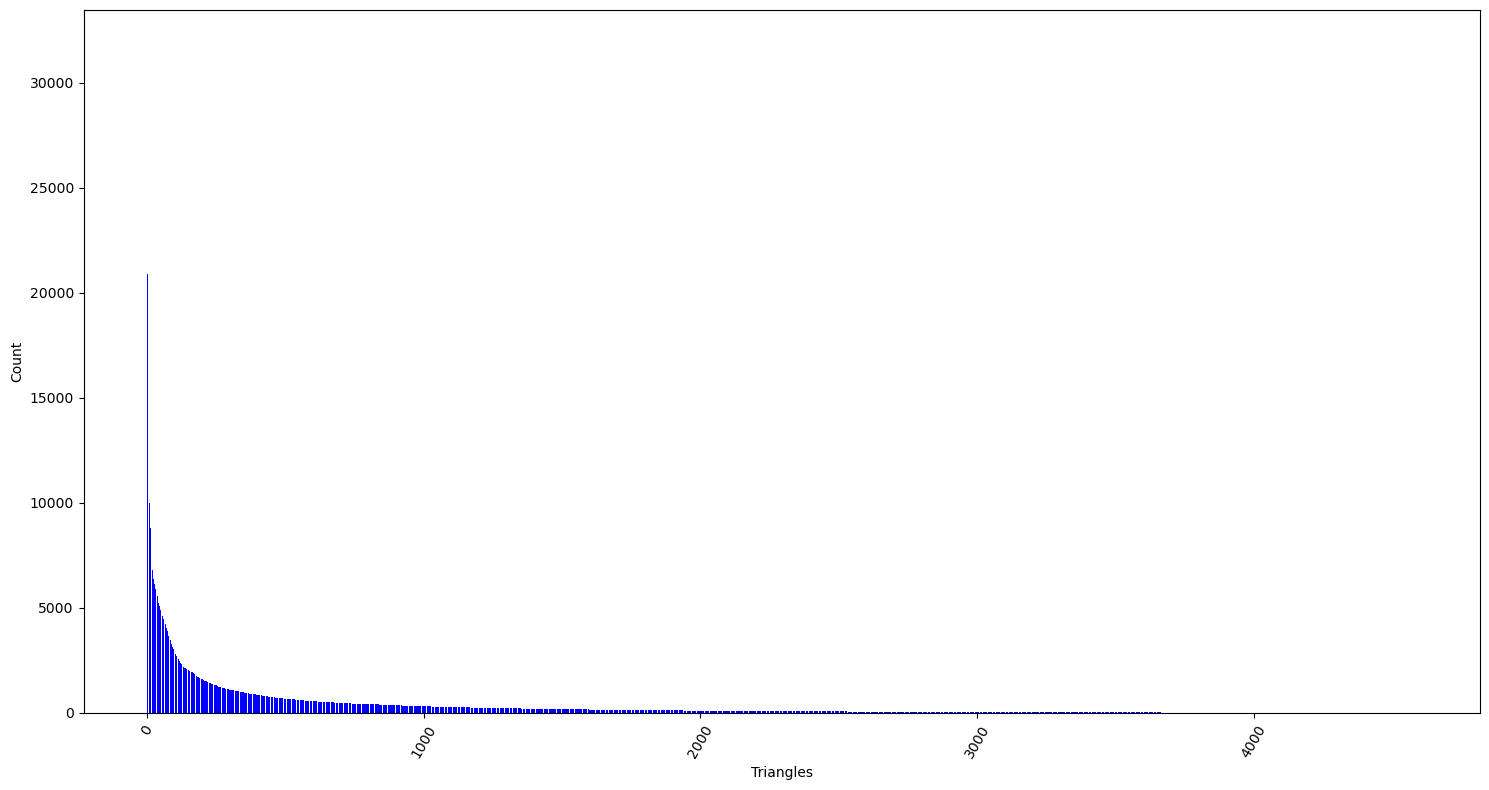

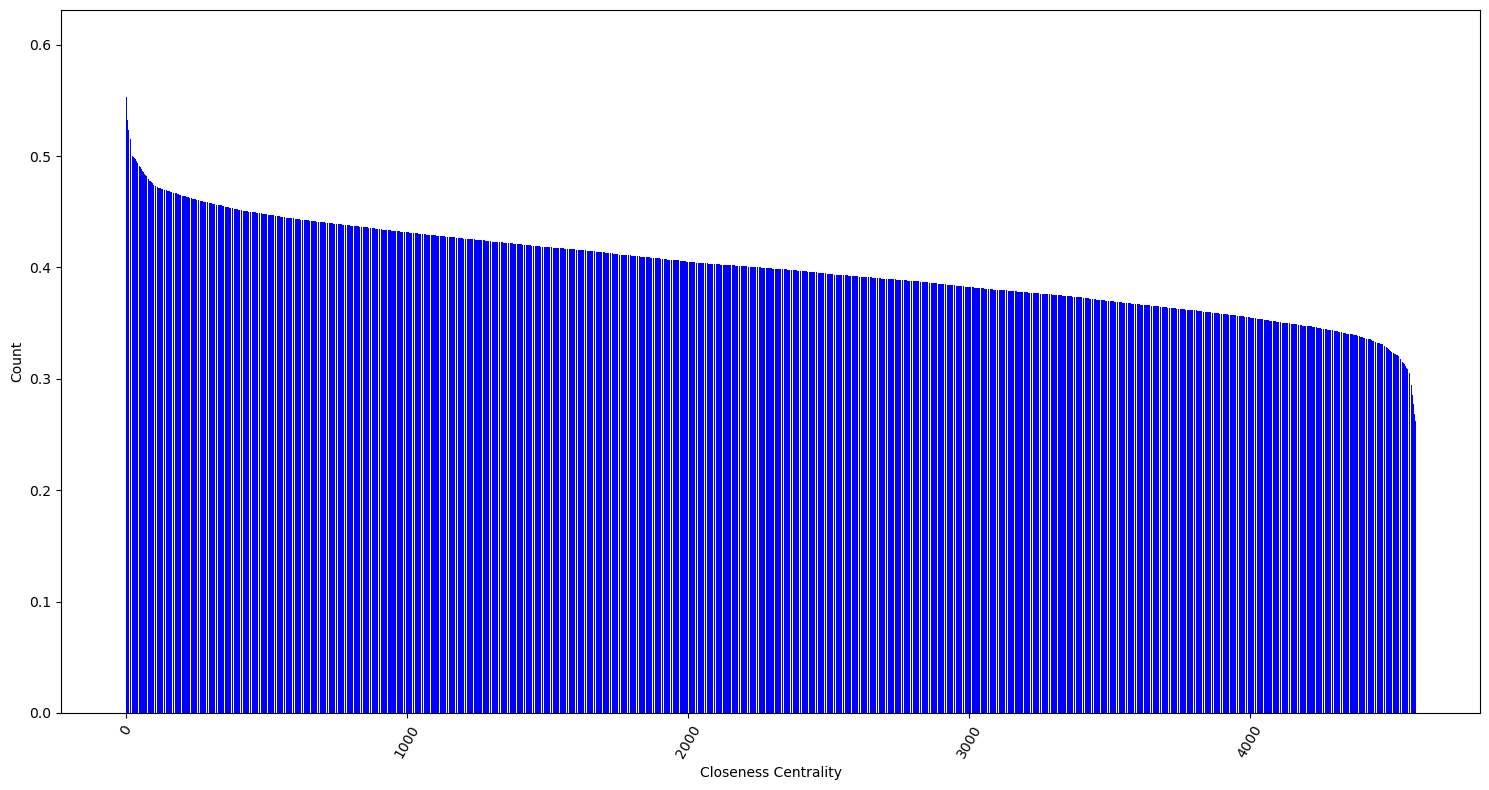

In [60]:
show_histogram(yvalues=[row[1] for row in triangles], figsize=(15,8), xlabel='Triangles')
show_histogram(yvalues=[row[1] for row in closeness], figsize=(15,8), xlabel='Closeness Centrality')

In [ ]:
cliques = nx.enumerate_all_cliques(H)

# convert the cliques to a list of cliques
list_cliques = list(cliques)

print('cliques: ', list_cliques ) 